# Numerical experiments on the Stokes sinker

This tutorial solves the *Stokes equation* numerically. The Stokes equation captures static force equilibrium for a laminar, low Reynolds number fluid. In this case, velocities and pressure within the fluid are entirely controlled by the density and viscosity distribution within the medium and the boundary conditions. The velocity solution is *instantaneous*, that is there is no time-dependence in the force balance (momentum conservation) part of the problem. For real problems, the flow that corresponds to the density anomaly will transport the density anomaly around, hence modifying the flow field over time, but this is only due to the transport, and at each instance, velocities are still in static equilibrium. In particular, there are no effects of inertia for sluggish, laminar flow. This flow regime holds for the mantle, and we will later add the diffusion and advvection of temperature (and hence density anomalies to the problem), leading to *convection*.

Here, we focus on the Stokes flow solution part, exploring cases similar to your experiments. Under the hood (the StokesLib.py part) we use a finite element method to solve the equations. This finite element method relies on *discretizing* the medium into little chunks, elements, and the associated mesh will affect the solution. The finer, the better, in general, but also the longer it takes to solve the equation, and the more memory is needed. We start below with some default settings, but you can change the resolution.



Let's load some packages. In particular, we use the FEniCS package to do the heavy lifting for the finite element part.

In [1]:
# loading packages
import numpy as np
import ufl
from dolfinx.fem import (Constant, Function, FunctionSpace, dirichletbc,
                         extract_function_spaces, form,
                         locate_dofs_topological, locate_dofs_geometrical)
from dolfinx.io import XDMFFile
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from mpi4py import MPI
from petsc4py import PETSc
from ufl import div, dx, grad, inner
from dolfinx import fem, la
from dolfinx.io import gmshio
from math import *
from dataclasses import dataclass,astuple,asdict # for C-like structure

from StokesLib import gmsh_stokes_tutorial, fem_main, block_iterative_solver, describeModel, runScenarioPlot
import pyvista
from dolfinx import plot

import warnings
warnings.filterwarnings("ignore")

Next, we define a parameter structure which has a large number of settings. Those are all you should have to modify, pretty much. We allow for a 2-D box, with an elliptical inclusion at given depth and orientation, and to set density and viscosity values. Read through those and the comments.

In [7]:
# model description: a top rectangle + a bottom rectangle + an elliptical inclusion inside the bottom rectangle.
# ---
# boundary descriptions:
# left boundary  : A
# bottom boundary: B
# right boundary : C
# top boundary   : D
# ---
# material properties:
@dataclass
class parameters: 
    # Adjustable parameters
    eta_crust = 1.  # viscosity of the upper block.
    eta_mantle = 1.  # viscosity of the bottom block.
    eta_inc = 1000.  # viscosity of the elliptical anomaly. 

    dgrav = 1. # delta gravity anomaly for the ellipse. 

    # ----------------------------------
    # adjustable parameters for the mesh.
    dxx = 0.1 # cell size near boundary points.

    w = 1.  # width of the model
    h_mantle = 0.8  # height of the bottom rectangle
    h_crust = 0.2 # heigth of the top rectangle

    xe = 0.5;  # x cooridnate of the ellipse center
    ye = 0.5; # y coordinate of the ellipse center
    # the center of the ellipse is at the center of the bottom rectangle at (xe,ye)=(w/2,h1/2).
    ra = 0.1 # a of the ellipse
    rb = 0.1 
    
    rot = 0.5*pi # rotation of the ellipse counterclockwise around its center in radians.

    bcs_type  = 1   # please choose the boundary conditions and the options could be expanded. 
    # 1: free slip for all surfaces A-D;
    # 2: free slip for A-C, D free.
    # 3: no slip for all A-D.
    # 4: no slip for B, fixed velocity for D, no y motion + tao_xy=0 for A and C. 

## Now let's go!

## Case 1: a high viscosity spherical density anomaly in a Newtonian fluid

NOTE: All adjustable parameters on model geometries, mechanical properties, and boundary conditions could and should be assigned through the data class parameters defined in the code cell above. The names of variables are given in the ()s below.  

### Model description: 

The model domain is 1 X 1 (w X [h_crust + h_mantle]). The thicknesses of the two layers - crust (h_crust) and mantle (h_mantle)- could be assigned, but in this model, we don't differentiate them. That is, there is a single, same viscosity layer.

There is a spherical density (dgrav)  anomaly that has a radius of 0.1 (ra and rb for the half major and minor axes of an ellipitical anomaly; set ra = rb = 0.1 for this spherical case) and higher viscosity of 1000 (eta_inc) compared to the reference viscosity of the surroundings (eta_crust and eta_mantle).

The x and y coordinantes of the center of the anomaly are xe and ye.  
 
The boundary conditions are free slip, i.e., no flow normal to the boundaries (bcs_type = 1). 

Model description.
A 2-D block that has two horizontal layers.
The thicknesses of the crust and mantle are  0.2 0.8  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.1 0.1  is inserted and its center is located at 0.5 0.5
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 1000.0  respectively.
The gravity anomaly for the ellipse is  1.0
Boundary conditions are  free slip for all surfaces.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 185 nodes
Info    : 368 elements
Info    : Done reading 'stokes.msh'
(B) Norm of velocity coefficient vector (blocked, iterative): 0.029670174262076122
(B) Norm of pressure coefficient vector (blocked, iterative): 0.22149486373922309


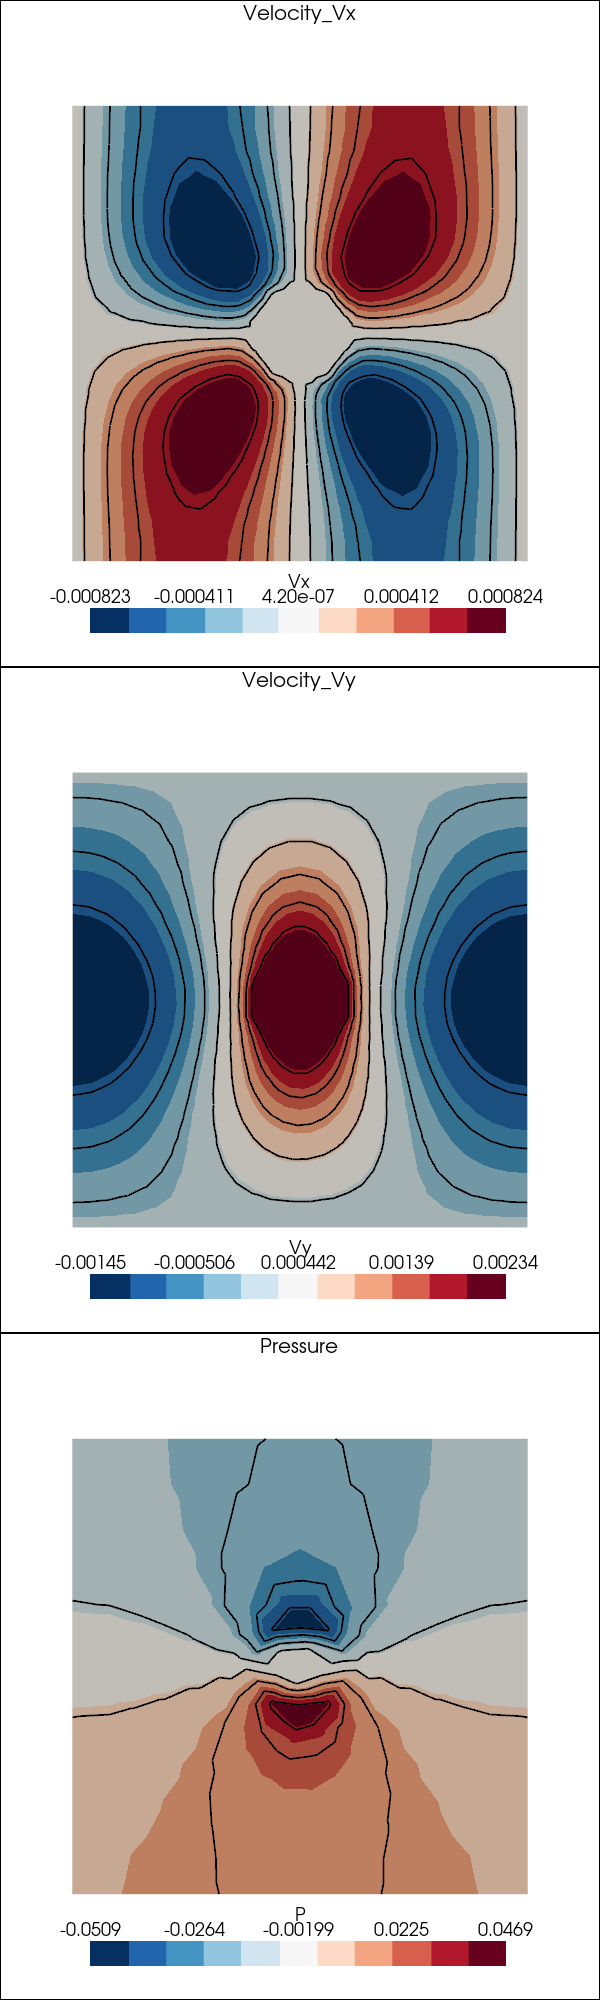

In [8]:
par = parameters()
par.w, par.h_mantle, par.h_crust = 1, 0.8, 0.2
par.xe, par.ye = 0.5, 0.5
par.ra, par.rb = 0.1, 0.1
par.eta_inc = 1000.
par.eta_mantle, par.eta_crust = 1., 1.
par.dgrav = 1.
par.bcs_type = 1
describeModel(par)
runScenarioPlot(par, plotStyle='scalar')

Inspect those solutions in light of your experiments. What do the different velocity components tell you about the flow? What physical processes do they tell you about?

Now run the same model but show velocities as vectors with mesh. This will make it easier to see what is happening, but a bit harder to read off amplitudes, which si something we need below.

Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 185 nodes
Info    : 368 elements
Info    : Done reading 'stokes.msh'
(B) Norm of velocity coefficient vector (blocked, iterative): 0.029670174262076122
(B) Norm of pressure coefficient vector (blocked, iterative): 0.22149486373922309


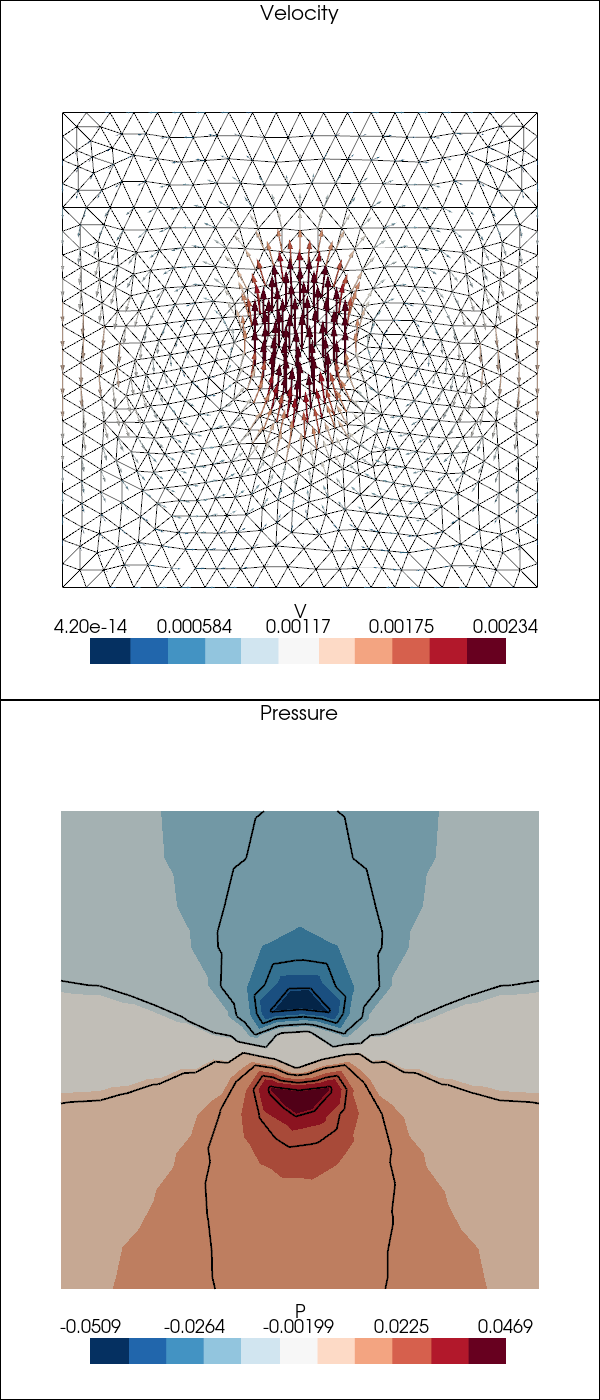

In [4]:
runScenarioPlot(par, plotStyle='vector')

## Case 2: what numerical resolutions should we use?

As mentioned, as with all numerical methods, the discretization matters. For finite elements, this mainly means worrying about the mesh that you could see in the plot above. Let us explore how fine the mesh should be, and what mesh size we should be using.

Grid size can be adjusted by changing dxx, whose default is 0.1.

What happens if you decrease dxx? Which ddx should be use to get a good reading of the solution, within which errors?


Model description.
A 2-D block that has two horizontal layers.
The thicknesses of the crust and mantle are  0.2 0.8  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.1 0.1  is inserted and its center is located at 0.5 0.5
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 1000.0  respectively.
The gravity anomaly for the ellipse is  1.0
Boundary conditions are  free slip for all surfaces.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 15375 nodes
Info    : 30748 elements
Info    : Done reading 'stokes.msh'
(B) Norm of velocity coefficient vector (blocked, iterative): 0.29340831621585184
(B) Norm of pressure coefficient vector (blocked, iterative): 2.0958238319633624


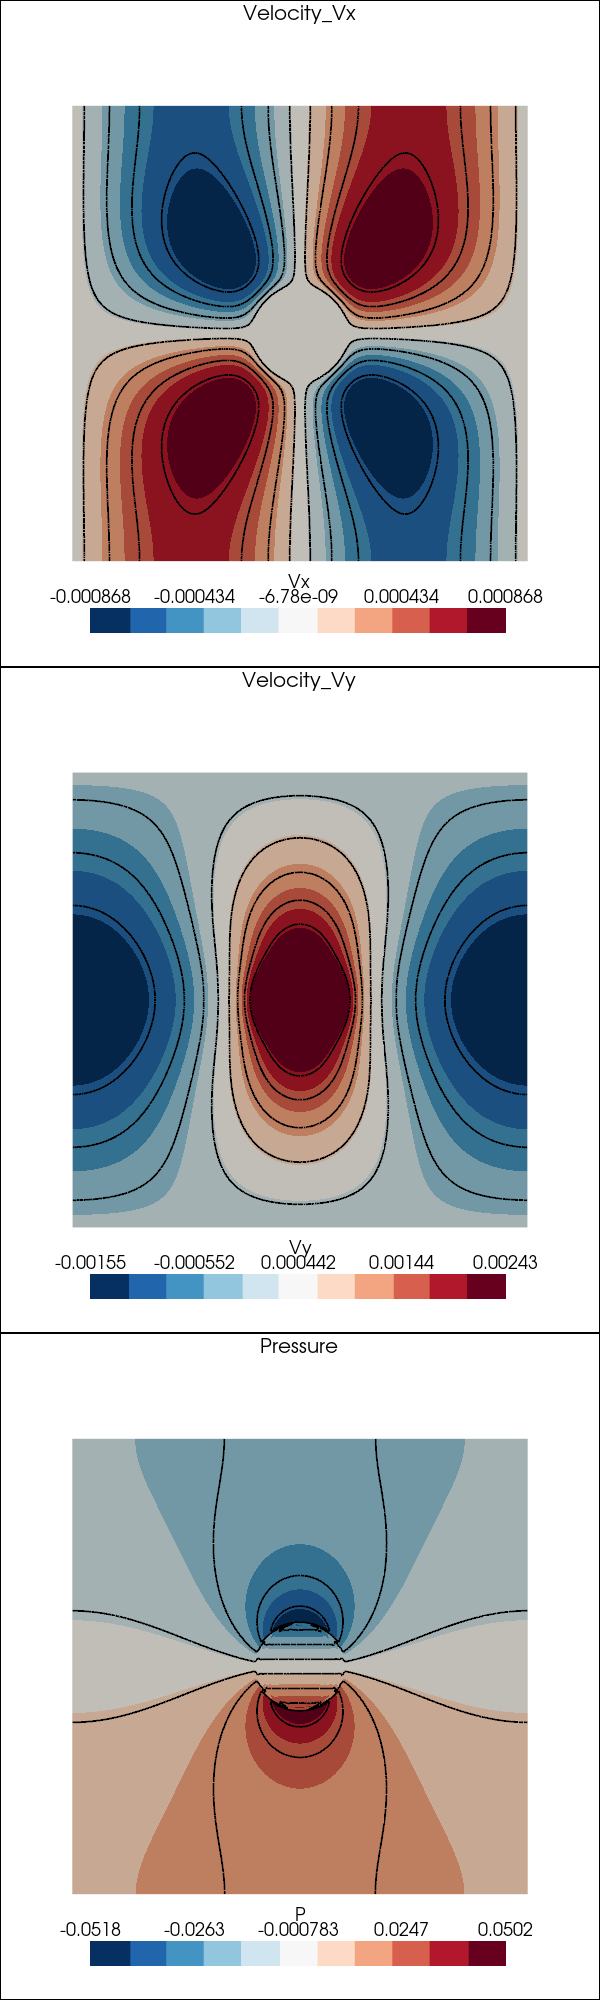

In [5]:
par = parameters()
par.dxx = 0.01
describeModel(par)
runScenarioPlot(par, plotStyle='scalar')

## Case 3: the effect of boundary conditions. 

First, let's examine the velocities and pressures for the best solution. 

What patterns do you observe, for example, where is velocity/pressure highest and lowest? 

What if we change the boundary condition of the top to free surface? (bcs_type = 2)

Model description.
A 2-D block that has two horizontal layers.
The thicknesses of the crust and mantle are  0.2 0.8  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.1 0.1  is inserted and its center is located at 0.5 0.5
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 1000.0  respectively.
The gravity anomaly for the ellipse is  1.0
Boundary conditions are  free slip for lateral sides and bottom, but the top is free.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 185 nodes
Info    : 368 elements
Info    : Done reading 'stokes.msh'
(B) Norm of velocity coefficient vector (blocked, iterative): 0.032657830216567665
(B) Norm of pressure coefficient vector (blocked, iterative): 1.2835503791533736


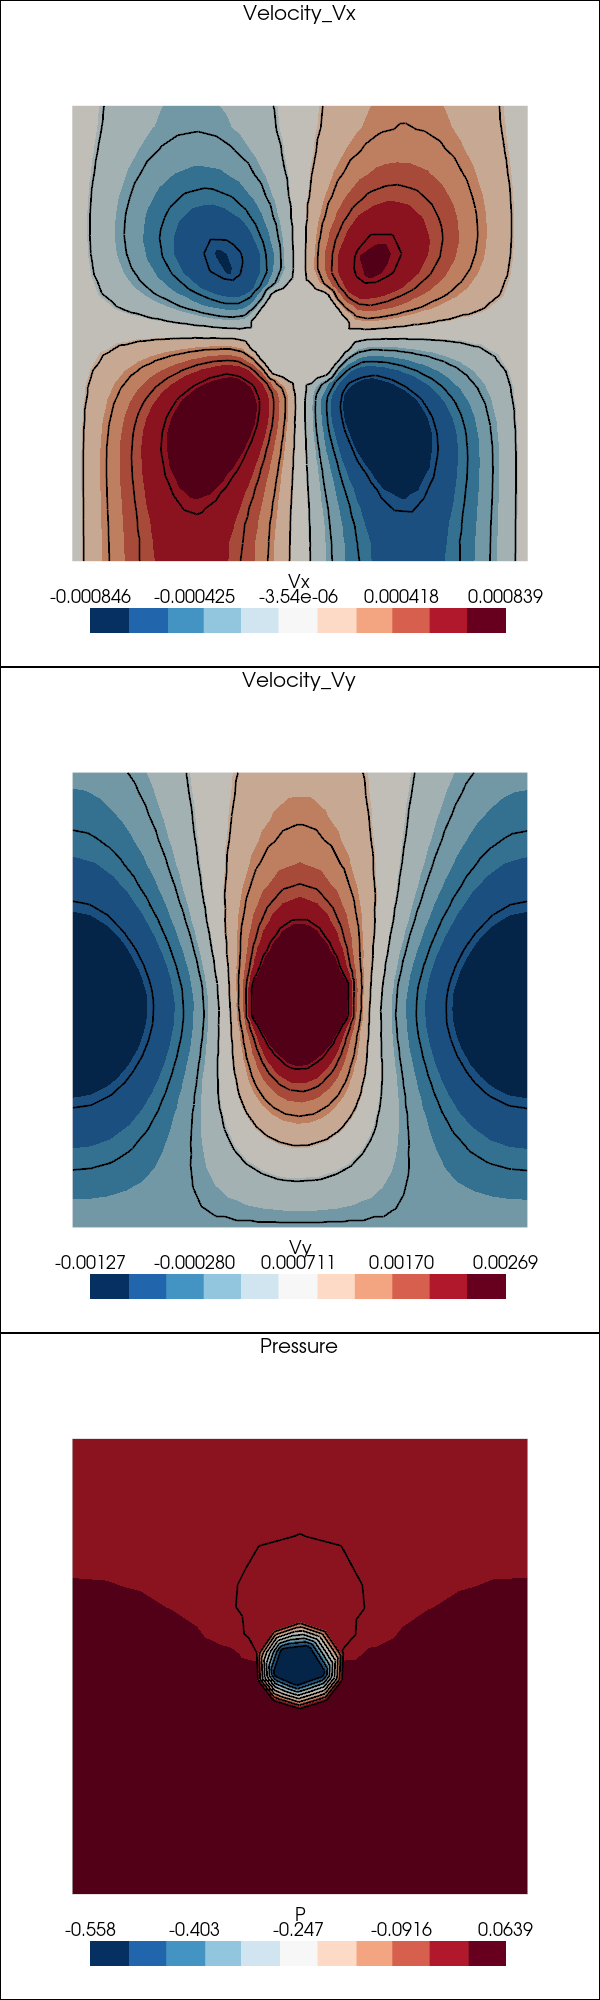

In [6]:
par = parameters()
par.bcs_type = 2
describeModel(par)
runScenarioPlot(par, plotStyle='scalar')

And what if we change the boundary conditions to no slip, i.e., zero velocities on all the boundaries. (bcs_type = 3) 

Model description.
A 2-D block that has two horizontal layers.
The thicknesses of the crust and mantle are  0.2 0.8  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.1 0.1  is inserted and its center is located at 0.5 0.5
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 1000.0  respectively.
The gravity anomaly for the ellipse is  1.0
Boundary conditions are  no slip at bottom, fixed velocity for top, and only horizontal motion and no shear traction for lateral sides.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 185 nodes
Info    : 368 elements
Info    : Done reading 'stokes.msh'
(B) Norm of velocity coefficient vector (blocked, iterative): 0.020695226651100098
(B) Norm of pressure coefficient vector (blocked, iterative): 0.26966538965440234


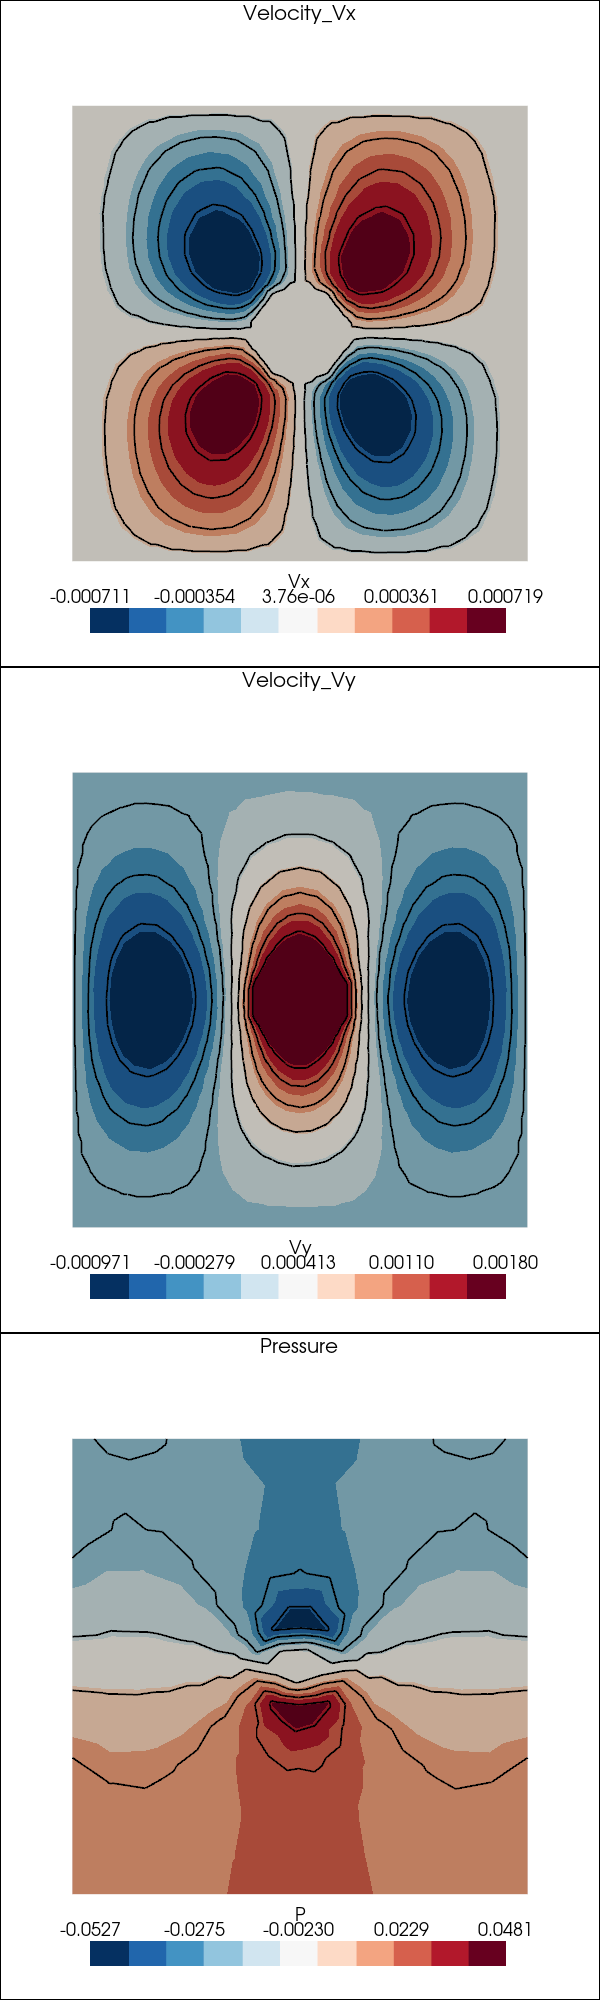

In [7]:
par = parameters()
par.bcs_type = 3
describeModel(par)
runScenarioPlot(par, plotStyle='scalar')

## Case 4: verify and determine the scaling relationship between velocities and density anomaly/viscosity

Let's go back to the default setup with free slip boundaries. 

Could you verify that the velocities scale with density anomaly/viscosity? 

1. Please run models with different $\Delta\rho g$ (dgrav) and record how maximum velocity and plot the relationship between the maximum velocity and $\Delta\rho g$.

2. Please do the same experiments for different viscosities. 

Take readings off the plots and compare those with the theoretical expectation you derived in the lab with the sinking sphere experiments. 


Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 185 nodes
Info    : 368 elements
Info    : Done reading 'stokes.msh'
(B) Norm of velocity coefficient vector (blocked, iterative): 0.3249864457793139
(B) Norm of pressure coefficient vector (blocked, iterative): 2.2477223354922886


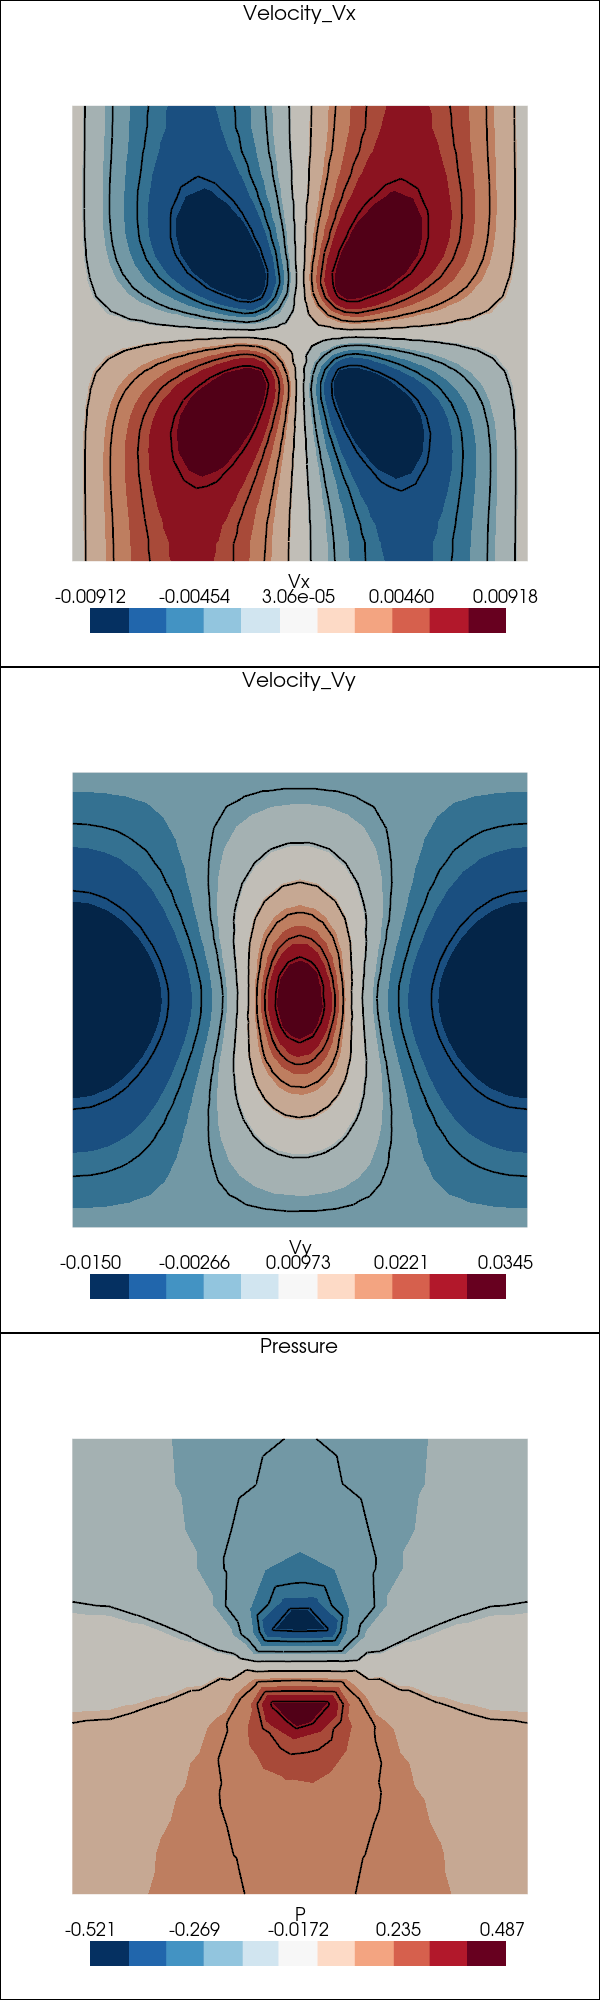

In [8]:
par = parameters()
par.dgrav = 10. # adjust it and record the maximum velocties
par.eta_crust, par.eta_mantle, par.eta_inc = 1., 1., 1. # make viscosities homogeneous
runScenarioPlot(par, plotStyle='scalar')

Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 185 nodes
Info    : 368 elements
Info    : Done reading 'stokes.msh'
(B) Norm of velocity coefficient vector (blocked, iterative): 0.030011648030546494
(B) Norm of pressure coefficient vector (blocked, iterative): 0.2208054214287452


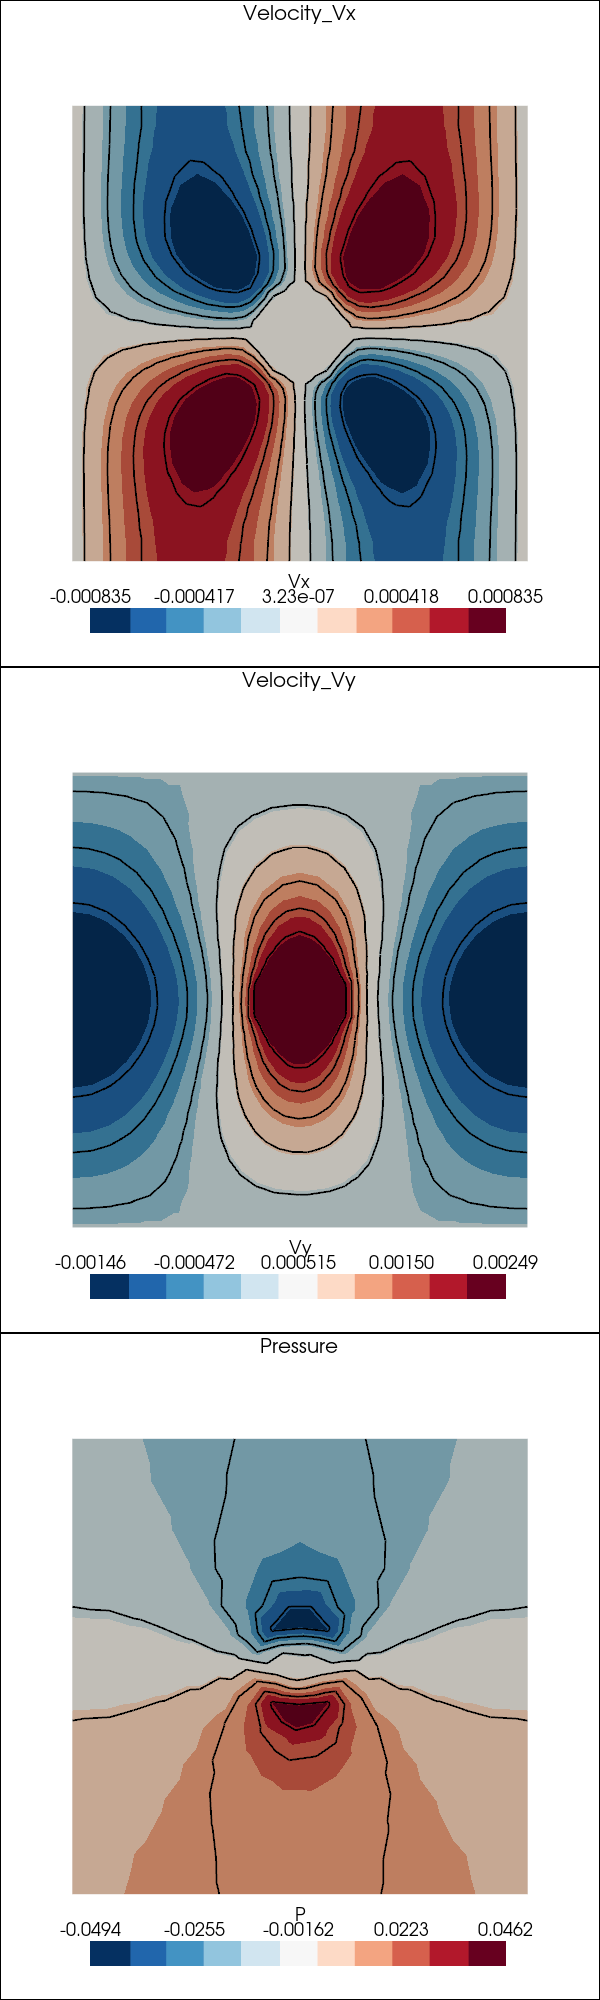

In [9]:
par = parameters()
par.eta_inc = 10. # adjust it and record the maximum velocties
runScenarioPlot(par, plotStyle='scalar')

Here you are provided with an analytical solution for maximum velocity 

$v=C[(\rho_{sphere}-\rho_{fluid})/\mu]gR^2$

Could you determine the scaling constant $C$ from your experiments? 

If you change the spheric anomaly to an elliptical one, will the scaling constant change? 

To get an elliptical anomaly, you can change ra, rb, and rotate the ellipse counterclockwise by setting rot in radians. For example

Model description.
A 2-D block that has two horizontal layers.
The thicknesses of the crust and mantle are  0.2 0.8  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.2 0.1  is inserted and its center is located at 0.5 0.5
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.3  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 1000.0  respectively.
The gravity anomaly for the ellipse is  1.0
Boundary conditions are  free slip for all surfaces.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 211 nodes
Info    : 420 elements
Info    : Done reading 'stokes.msh'
(B) Norm of velocity coefficient vector (blocked, iterative): 0.05546458232149806
(B) Norm of pressure coefficient vector (blocked, iterative): 0.4612396237413758


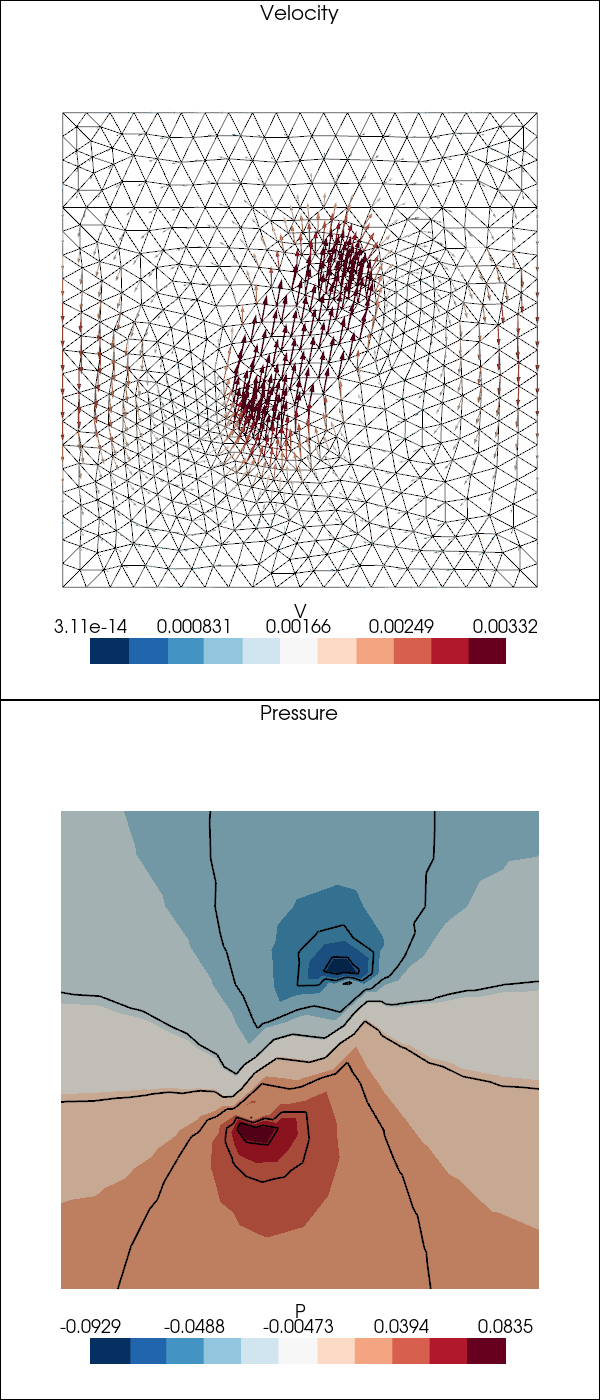

In [10]:
par = parameters()
par.ra, par.rb, par.rot = 0.2, 0.1, 0.3*pi
describeModel(par)
runScenarioPlot(par, plotStyle='vector')

What if the sphere is moved up or down? What happens to velocities and pressures?

Model description.
A 2-D block that has two horizontal layers.
The thicknesses of the crust and mantle are  0.2 0.8  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.1 0.1  is inserted and its center is located at 0.5 0.7
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 1000.0  respectively.
The gravity anomaly for the ellipse is  1.0
Boundary conditions are  free slip for all surfaces.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 183 nodes
Info    : 364 elements
Info    : Done reading 'stokes.msh'
(B) Norm of velocity coefficient vector (blocked, iterative): 0.02673805759722674
(B) Norm of pressure coefficient vector (blocked, iterative): 0.19627020828365718


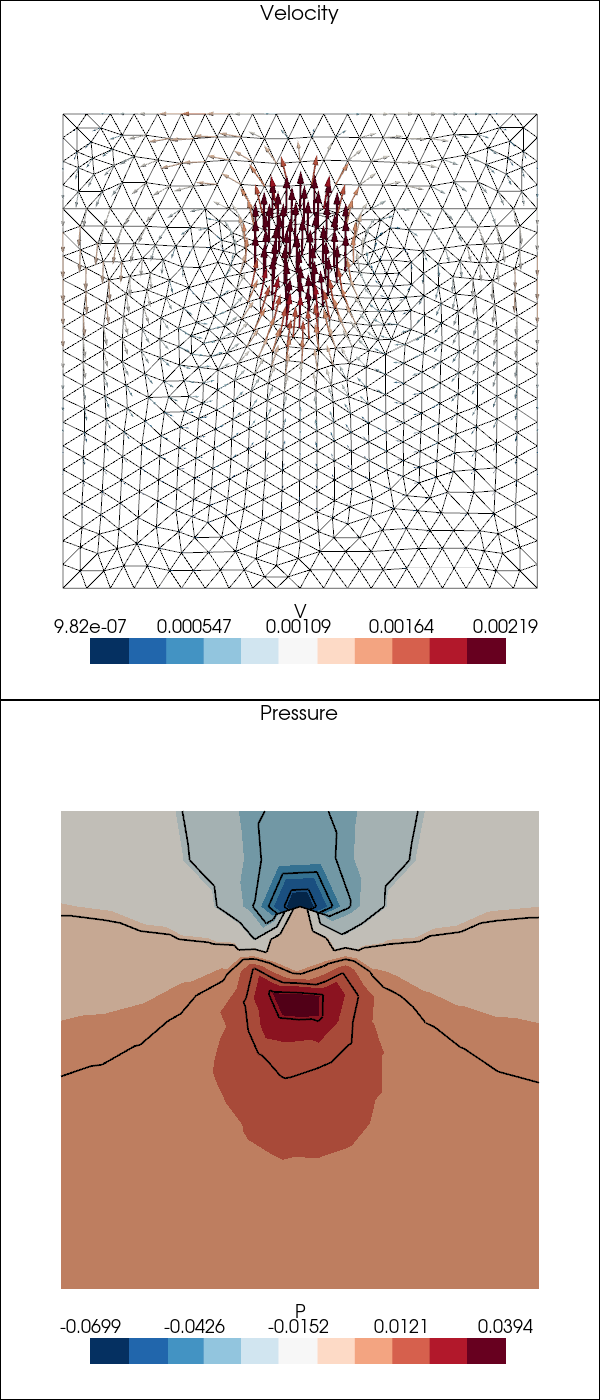

In [11]:
par = parameters()
par.ye = 0.7 # move the spheric anomaly up or down; please adjust it. NOTE, make sure the sphere is not out of bounds. The function modelGeometryCheck called by describeModel will verify it.
describeModel(par)
runScenarioPlot(par, plotStyle='vector')

What if the model domain is enlarged 3 times? Or 5 or 10 times?  

How big do you have to make the box so that the sphere does not "feel" the boundaries anymore?


Model description.
A 2-D block that has two horizontal layers.
The thicknesses of the crust and mantle are  0.6 2.4  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.1 0.1  is inserted and its center is located at 1.5 1.5
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 1000.0  respectively.
The gravity anomaly for the ellipse is  1.0
Boundary conditions are  free slip for all surfaces.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 1381 nodes
Info    : 2760 elements
Info    : Done reading 'stokes.msh'
(B) Norm of velocity coefficient vector (blocked, iterative): 0.09937450534360208
(B) Norm of pressure coefficient vector (blocked, iterative): 0.25406889172999486


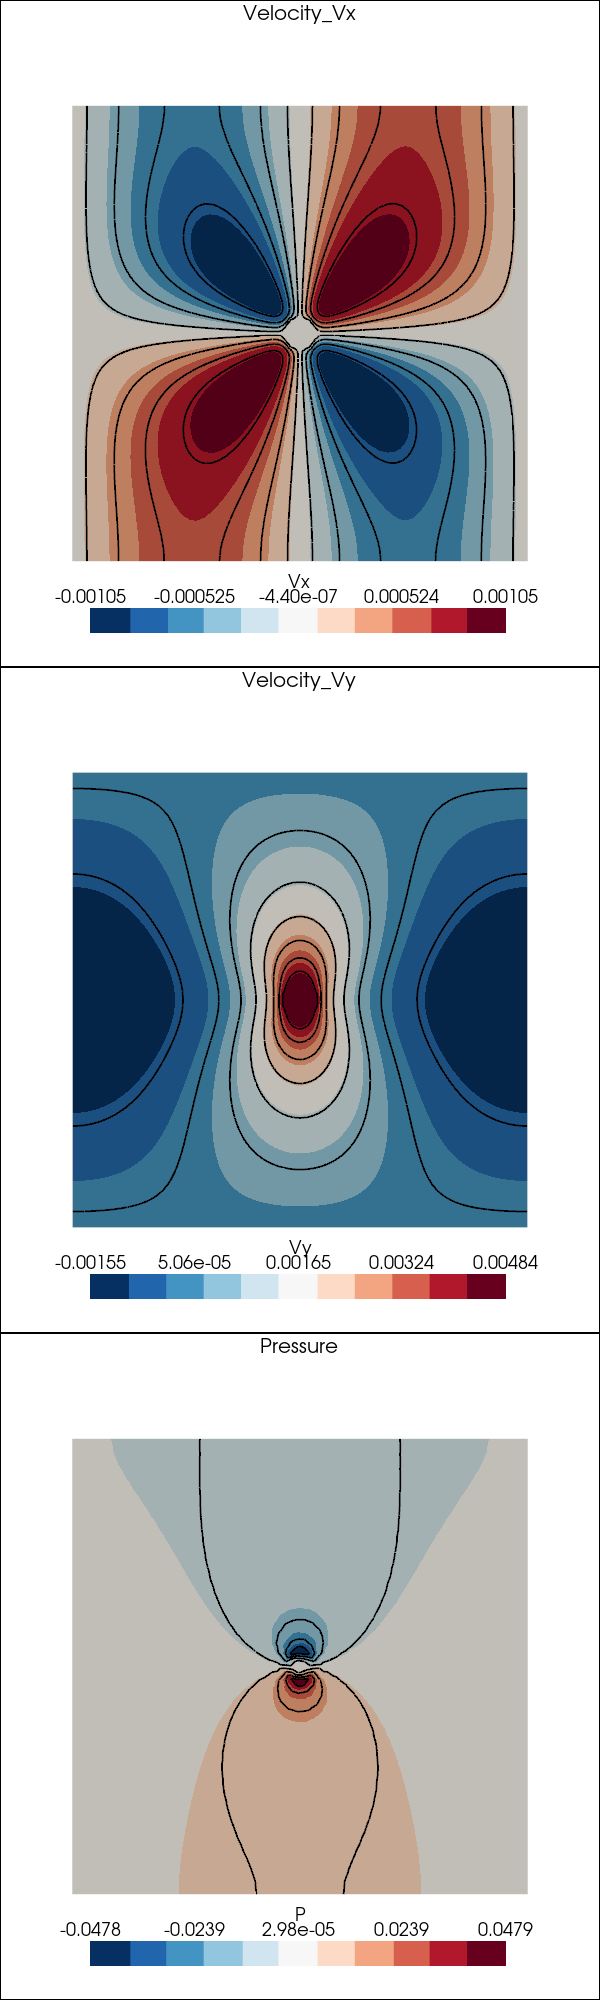

In [12]:
par = parameters()
par.w, par.h_crust, par.h_mantle = 3, 0.6, 2.4
par.xe, par.ye = 1.5, 1.5
describeModel(par)
runScenarioPlot(par, plotStyle='scalar')

## Case 5: the effect of viscosity contrast
Now we explore how maximum (or mean) velocities (where) as a function of viscosity contrast between the ellipse and surrounding mantle. 

Could you change the viscosity of eta_inc to 10,000, 100, 1, 0.01, 0.00001, and record maximum velocities and plot them against eta_inc? Note that the default eta_crust and eta_mantle are 1, and eta_inc of the anomaly is the same as the viscosity contrast. 

Model description.
A 2-D block that has two horizontal layers.
The thicknesses of the crust and mantle are  0.2 0.8  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.1 0.1  is inserted and its center is located at 0.5 0.5
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 0.01  respectively.
The gravity anomaly for the ellipse is  1.0
Boundary conditions are  free slip for all surfaces.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 185 nodes
Info    : 368 elements
Info    : Done reading 'stokes.msh'
(B) Norm of velocity coefficient vector (blocked, iterative): 0.04639416427290734
(B) Norm of pressure coefficient vector (blocked, iterative): 0.289410620823092


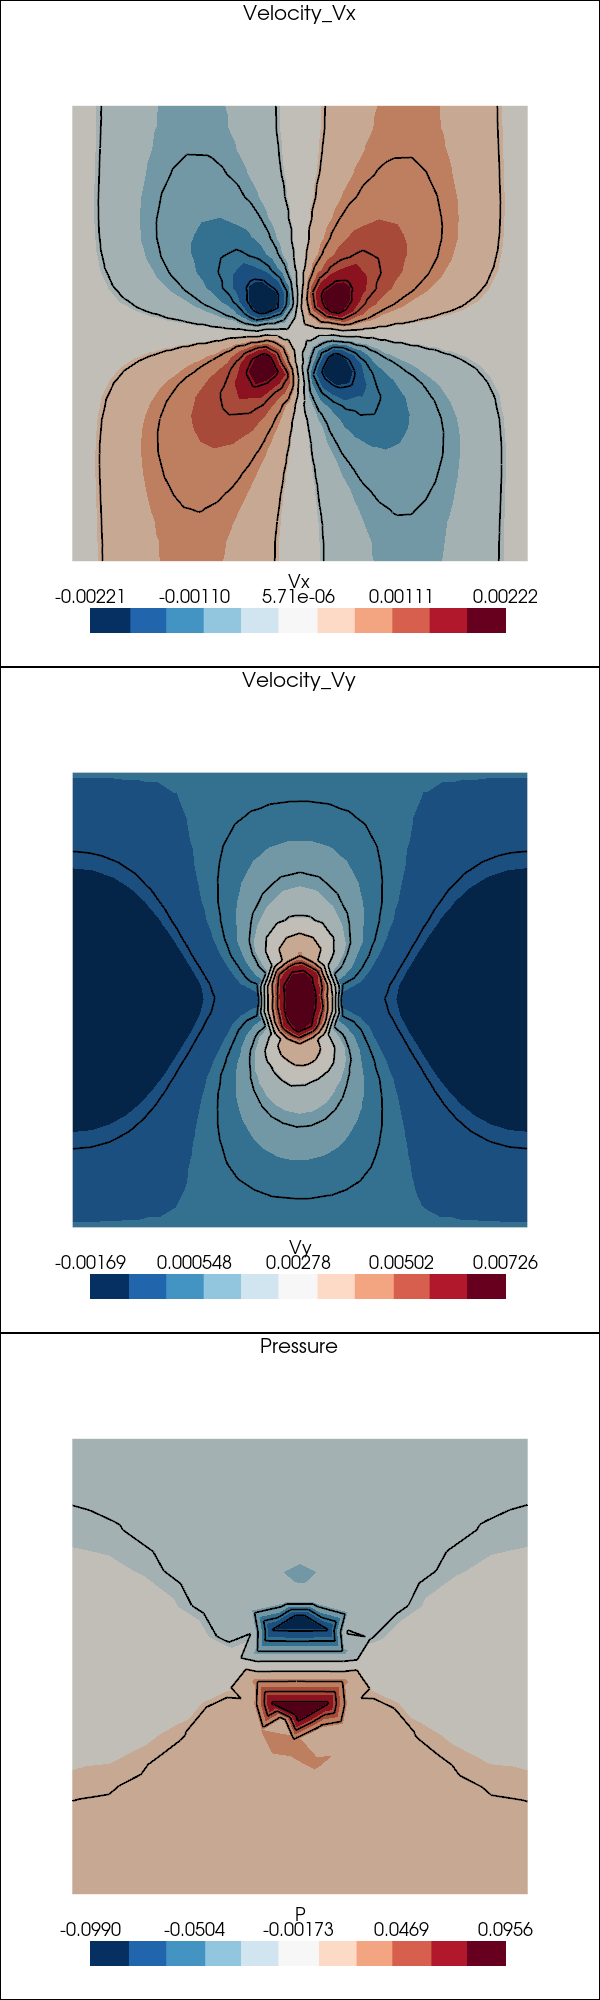

In [12]:
par = parameters()
par.eta_inc = 0.01 # please adjust it for different viscosity contrast
describeModel(par)
runScenarioPlot(par, plotStyle='scalar')

## Case 6: the effect of ellipticity and orientations of the anomaly.

Let's change the spheric anomaly to an ellipse of 0.5 by 0.05, and also rotate the ellipse, to see how the velocities and pressures change. 

Model description.
A 2-D block that has two horizontal layers.
The thicknesses of the crust and mantle are  0.2 1.5  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.4 0.1  is inserted and its center is located at 0.75 0.75
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 1000.0  respectively.
The gravity anomaly for the ellipse is  1.0
Boundary conditions are  free slip for all surfaces.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 431 nodes
Info    : 860 elements
Info    : Done reading 'stokes.msh'
(B) Norm of velocity coefficient vector (blocked, iterative): 0.165902589062704
(B) Norm of pressure coefficient vector (blocked, iterative): 0.9968930389168479


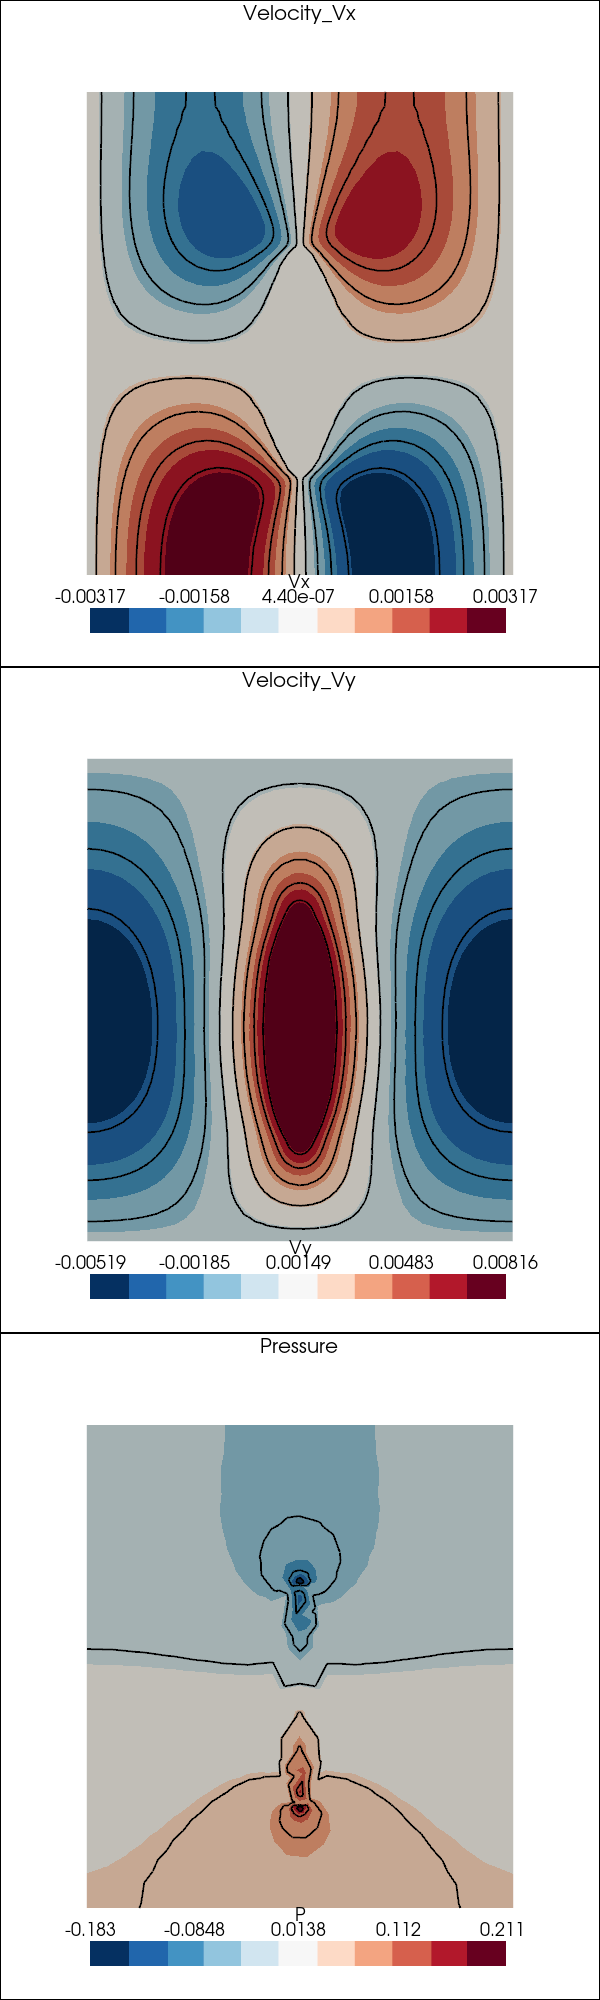

In [14]:
par = parameters()
par.w, par.h_mantle = 1.5, 1.5
par.dxx = 0.1
par.xe, par.ye = par.w/2, par.h_mantle/2
par.ra, par.rb, par.rot = 0.4, 0.1, 0.5*pi
describeModel(par)
runScenarioPlot(par, plotStyle='scalar')